In [1]:
import tensorflow as tf
from pathlib import Path
from tensorflow import keras
from keras.preprocessing.image import ImageDataGenerator

In [2]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [3]:
fdata = f'../../data/sars-cov2-ct-scan'

p = Path(fdata)
ptrain = p / 'train'
ptest = p / 'test'
pval = p / 'val'

In [4]:
BATCH_SIZE = 10

w, h = (224, 224)

train_generator = ImageDataGenerator()

val_generator = ImageDataGenerator()

test_generator = ImageDataGenerator()

In [5]:
traingen = train_generator.flow_from_directory(ptrain,
                                               target_size=(w, h),
                                               class_mode='binary',
                                               batch_size=BATCH_SIZE, 
                                               shuffle=True,
                                               seed=42)

validgen = val_generator.flow_from_directory(pval,
                                               target_size=(w, h),
                                               class_mode='binary',
                                               batch_size=BATCH_SIZE,
                                               shuffle=True,
                                               seed=42)

testgen = test_generator.flow_from_directory(ptest,
                                             target_size=(w, h),
                                             class_mode='binary',
                                             batch_size=1,
                                             shuffle=False,
                                             seed=42)

Found 1788 images belonging to 2 classes.
Found 198 images belonging to 2 classes.
Found 495 images belonging to 2 classes.


In [6]:
traingen.classes

array([0, 0, 0, ..., 1, 1, 1])

In [7]:
traingen.batch_index

0

In [8]:
base_model = keras.applications.VGG16(
    weights='imagenet',  # Load weights pre-trained on ImageNet.
    input_shape=(w, h, 3),
    include_top=False)

In [9]:
base_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [15]:
#Freeze the base model
base_model.trainable = False
for layer in base_model.layers[:-3]:
    layer.trainable = True

In [16]:
for layer in base_model.layers:
    print(layer.trainable)

True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
False
False
False


In [17]:
inputs = keras.Input(shape=(w, h, 3))
x = base_model(inputs)
x = keras.layers.Flatten()(x)
x = keras.layers.Dense(512, activation='relu')(x)
outputs = keras.layers.Dense(1, activation='sigmoid')(x)
model = keras.Model(inputs, outputs)

In [18]:
save_model = tf.keras.callbacks.ModelCheckpoint(
    filepath='models/vgg16/tl-vgg16-relu-rmsprop-model_{epoch:02d}.h5')

save_weight = tf.keras.callbacks.ModelCheckpoint(
    filepath='models/vgg16/tl-vgg16-relu-rmsprop-weight_{epoch:02d}.h5',
    save_weights_only=True)

lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-2,
    decay_steps=10000,
    decay_rate=0.9)

model.compile(optimizer=keras.optimizers.Adam(learning_rate=lr_schedule),
              loss=keras.losses.BinaryCrossentropy(),
              metrics=[keras.metrics.BinaryAccuracy()])
history = model.fit(traingen, epochs=20, validation_data= validgen,
             callbacks=[save_model, save_weight])

Epoch 1/20
179/179 [==============================] - 22s 100ms/step - loss: 54.6083 - binary_accuracy: 0.8809 - val_loss: 2.2683 - val_binary_accuracy: 0.8485
Epoch 2/20
179/179 [==============================] - 17s 92ms/step - loss: 0.0873 - binary_accuracy: 0.9871 - val_loss: 1.6902 - val_binary_accuracy: 0.8636
Epoch 3/20
179/179 [==============================] - 17s 93ms/step - loss: 0.0078 - binary_accuracy: 0.9972 - val_loss: 1.3994 - val_binary_accuracy: 0.8535
Epoch 4/20
179/179 [==============================] - 18s 97ms/step - loss: 1.6894e-04 - binary_accuracy: 1.0000 - val_loss: 1.4084 - val_binary_accuracy: 0.8485
Epoch 5/20
179/179 [==============================] - 17s 94ms/step - loss: 6.5609e-05 - binary_accuracy: 1.0000 - val_loss: 1.4177 - val_binary_accuracy: 0.8485
Epoch 6/20
179/179 [==============================] - 18s 97ms/step - loss: 5.0323e-05 - binary_accuracy: 1.0000 - val_loss: 1.4274 - val_binary_accuracy: 0.8485
Epoch 7/20
179/179 [==================

dict_keys(['loss', 'binary_accuracy', 'val_loss', 'val_binary_accuracy'])


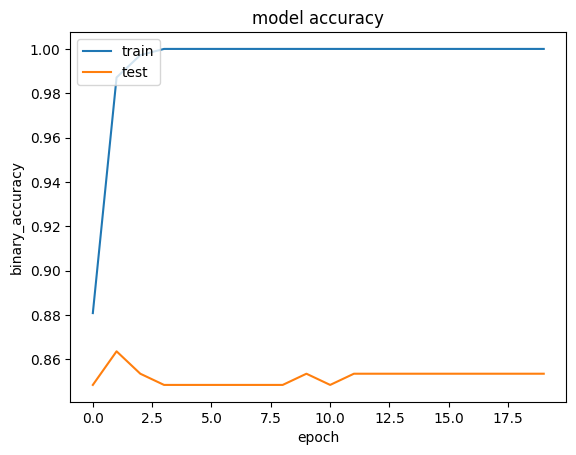

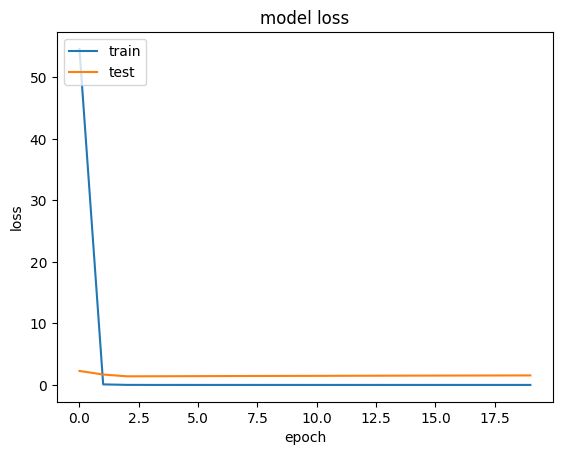

In [21]:
# list all data in history
print(history.history.keys())

import matplotlib.pyplot as plt

# summarize history for accuracy
plt.plot(history.history['binary_accuracy'])
plt.plot(history.history['val_binary_accuracy'])
plt.title('model accuracy')
plt.ylabel('binary_accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()